# Análisis de la optimización de carriles

Primero se define la función matemática que representa cada plano de cada uno de los patios. Tras tener dichas funciones, se analiza la distribución del ancho de los equipos, para seleccionar el ancho de los carriles. Teniendo un ancho definido para los carriles y las funciones, se posibilita la optimización de los planos.

## Determinar función matemática de los planos

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
from joblib import dump

# Define a custom estimator class that wraps numpy.poly1d
class PolyRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, degree=1):
        self.degree = degree

    def fit(self, X, y=None):
        self.coeffs = np.polyfit(X.squeeze(), y, self.degree)
        return self

    def predict(self, X):
        return np.polyval(self.coeffs, X.squeeze())


class BestFunc():
    def __init__(self, y, dx, title, max_degree=10, degree=1):
        self.y = y
        self.title = title
        self.x = np.arange(len(y))*dx
        self.max_degree = max_degree
        self.model = None
        self.best_degree = None
        self._generate_model()
    
    def _generate_model(self):
        # Initialize lists to store the cross-validation scores and the degree values
        cv_scores = []
        degrees = np.arange(1, self.max_degree+1)

        # Loop over the degree values and calculate the cross-validation scores for each degree
        for degree in degrees:
            # Create a PolyRegressor object with the current degree
            model = PolyRegressor(degree=degree)

            # Calculate the cross-validation score for this degree
            cv_score = np.mean(cross_val_score(model, self.x.reshape(-1, 1), self.y, cv=5, scoring='neg_mean_squared_error'))
            cv_scores.append(cv_score)

        # Find the degree with the best cross-validation score
        self.best_degree = degrees[np.argmin(cv_scores)]

        # Print the best degree
        #print(f"The best degree is {self.best_degree}")

        # Fit a polynomial regression with the best degree to the data points
        model = PolyRegressor(degree=self.best_degree)
        model.fit(self.x.reshape(-1, 1), self.y)

        self.model = model
    
    def generate_plot(self, with_slots=False):
        
        # Generate x-values to plot the regression line
        x_values = np.linspace(1, self.x[-1], 100)

        # Calculate the y-values of the regression line
        y_values = self.model.predict(x_values.reshape(-1, 1))

        # Plot the data points and the regression line
        plt.scatter(self.x, self.y, label='Data points')
        plt.plot(x_values, y_values, label=f"Polynomial regression (degree={self.best_degree})")

        # Add a legend and axis labels
        plt.legend()
        plt.xlabel('X values')
        plt.ylabel('Y values')
        plt.title(f'{self.title} function')

        # Show the plot
        if(not with_slots):
            plt.show()
    
    def generate_plot_with_slots(self, slot_width, angle):

        self.generate_plot(with_slots=True)
        # Generate x-values to plot the vertical lines
        x_vertical = np.arange(slot_width*(-5), self.x[-1]+slot_width, slot_width)
        poly_func = self.model.predict

        theta = np.deg2rad(angle)
        m = np.tan(theta)

        # Find the intersection points between the vertical lines and the polynomial regression line
        intersection_points = []
        y_intersect = 0

        x_vals = np.arange(0,self.x[-1],0.1)

        for i in range(len(x_vertical)):
            x0 = x_vertical[i]
            y0 = 0
            line_func = lambda x: m*(x-x0) + y0
            #line_func = lambda x: m*(x-x0) + y0 if m*(x-x0) + y0 >= 0 else 0

            # Encontrar el punto de intersección entre la línea recta y la función polinómica
            def intersection_func(x):
                return abs(poly_func(x) - line_func(x))

            y_diff = 1

            found = False
            for x_val in x_vals:
                y_diff = intersection_func(x_val)

                if(y_diff <= 0.5):
                    x_intersect = x_val
                    y_intersect = line_func(x_intersect)
                    found = True
                    break
            
            if found : intersection_points.append((x0, x_intersect, y0, y_intersect))
            


        # Plot the vertical lines and intersection points
        #print(intersection_points)
        for point in intersection_points:
            x_coords = [point[0], point[1]]
            y_coords = [point[2], point[3]]
            plt.plot(x_coords, y_coords, color='green')

        # Set the x-axis limits to start from the minimum x-value of the polynomial regression line
        plt.xlim(left=min(x_vals))

        # Show the plot
        plt.show()

    def save_model(self):
        dump(self.model, f'math_models/{self.title.replace(" ", "")}.joblib')


c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: RankWarning: Polyfit may be poorly conditioned
  estimator.fit(X_train, y_train, **fit_params)
c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: RankWarning: Polyfit may be poorly conditioned
  estimator.fit(X_train, y_train, **fit_params)
c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: RankWarning: Polyfit may be poorly conditioned
  estimator.fit(X_train, y_train, **fit_params)
c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: RankWarning: Polyfit may be poorly conditioned
  estimator.fit(X_train, y_train, **fit_params)
c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: RankWarning: Polyfit may be poorly conditioned
  estimator.fit(X_train, y_train, **fit_params)
c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: RankWarning: Polyfit may be poorly conditioned
  estimator.fit(X_train, y_t

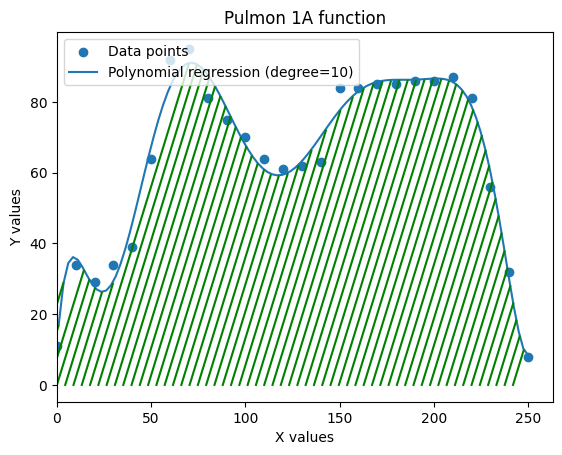

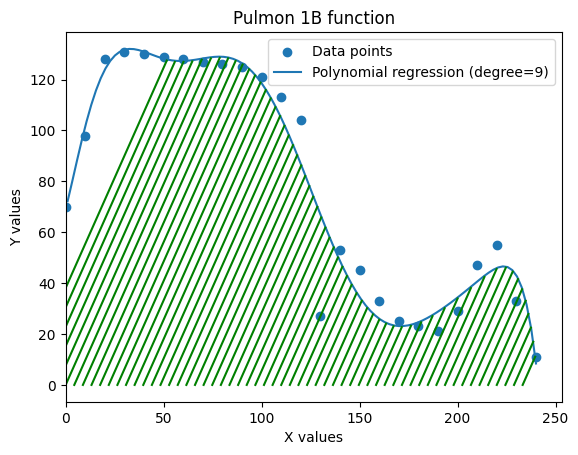

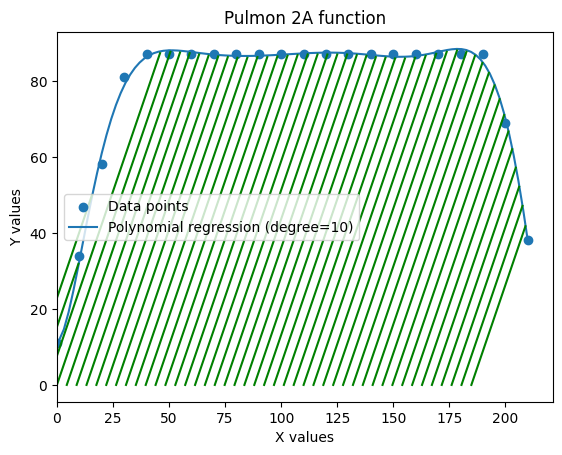

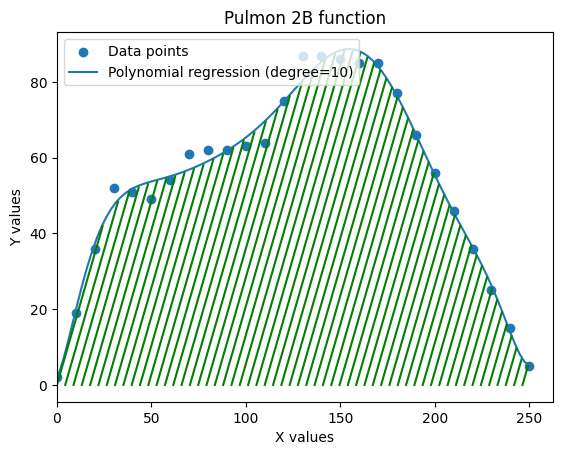

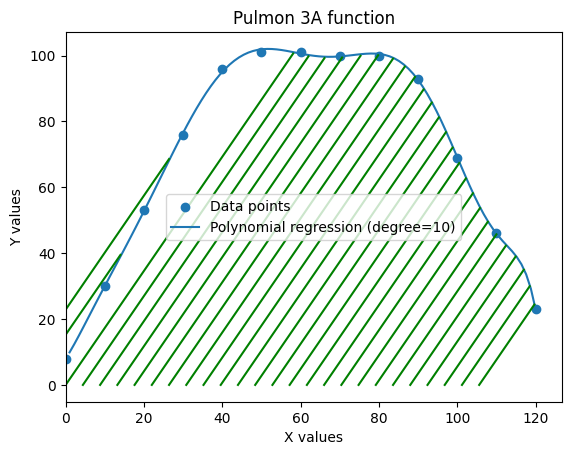

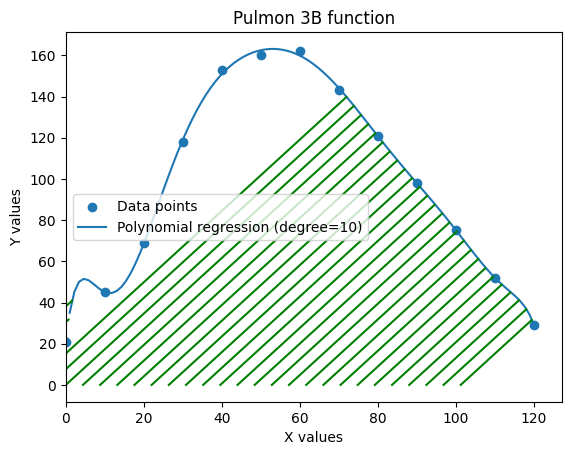

In [24]:
# Get the planes data from the excel file
import pandas as pd

warehouses = pd.read_excel("inputs/WarehouseDimensions.xlsx")
def split_inventory(original_inv, column_name):
    """
    """

    invs = {}
    for name, group in original_inv.groupby(column_name):
        invs[name] = group

    return invs

# Split the datasets by place
ws_by_plane = split_inventory(warehouses,'PLANO')
ws = {}

for w in ws_by_plane:
    ws_divs = split_inventory(ws_by_plane[w],'DIVISION')
    for key in ws_divs:
        ws[w + key] = ws_divs[key]

# Get the models for every place
models = {}
for place in ws:
    y = ws[place]['LONGITUD']
    models[place] = BestFunc(y=y,dx=10,title=place)


# Generate graphs
for place in models:
    models[place].generate_plot_with_slots(4.4,60)

In [6]:
for place in models:
    models[place].save_model()

The best degree is 10


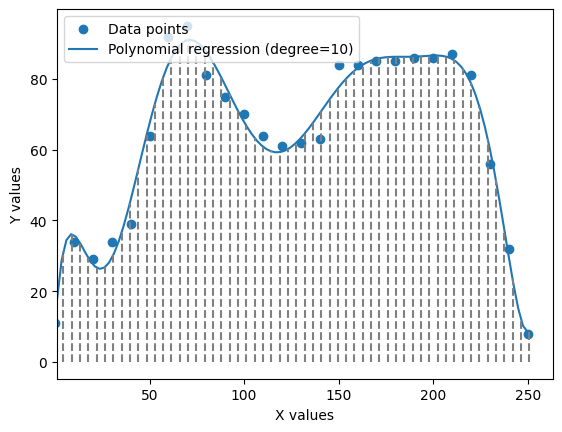

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

# Define a custom estimator class that wraps numpy.poly1d
class PolyRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, degree=1):
        self.degree = degree
 
    def fit(self, X, y=None):
        self.coeffs = np.polyfit(X.squeeze(), y, self.degree)
        return self

    def predict(self, X):
        return np.polyval(self.coeffs, X.squeeze())

# Define your data points
y = np.array([11, 34, 29, 34, 39, 64, 92, 95, 81, 75, 70, 64, 61, 62, 63, 84, 84, 85, 85, 86, 86, 87, 81, 56, 32, 8])

# Create x as a range of integers from 1 to 26
x = np.arange(len(y))*10

# Set the maximum degree of the polynomial
max_degree = 10

# Initialize lists to store the cross-validation scores and the degree values
cv_scores = []
degrees = np.arange(1, max_degree+1)

# Loop over the degree values and calculate the cross-validation scores for each degree
for degree in degrees:
    # Create a PolyRegressor object with the current degree
    model = PolyRegressor(degree=degree)

    # Calculate the cross-validation score for this degree
    cv_score = np.mean(cross_val_score(model, x.reshape(-1, 1), y, cv=5, scoring='neg_mean_squared_error'))
    cv_scores.append(cv_score)

# Find the degree with the best cross-validation score
best_degree = degrees[np.argmin(cv_scores)]

# Print the best degree
print(f"The best degree is {best_degree}")

# Fit a polynomial regression with the best degree to the data points
model = PolyRegressor(degree=best_degree)
model.fit(x.reshape(-1, 1), y)

# Generate x-values to plot the regression line
x_values = np.linspace(1, x[-1], 100)

# Calculate the y-values of the regression line
y_values = model.predict(x_values.reshape(-1, 1))

# Plot the data points and the regression line
plt.scatter(x, y, label='Data points')
plt.plot(x_values, y_values, label=f"Polynomial regression (degree={best_degree})")

# Add a legend and axis labels
plt.legend()
plt.xlabel('X values')
plt.ylabel('Y values')

# Generate x-values to plot the vertical lines
x_vertical = np.arange(0, x[-1]+4.4, 4.4)

# Find the intersection points between the vertical lines and the polynomial regression line
intersection_points = []
for i in range(len(x_vertical)):
    x_i = x_vertical[i]
    y_i = 0
    y_poly = model.predict(np.array([[x_i]])).item()
    if y_i <= y_poly:
        intersection_points.append((x_i, y_poly))

# Plot the vertical lines and intersection points
for point in intersection_points:
    plt.plot([point[0], point[0]], [0, point[1]], linestyle='--', color='grey')

# Set the x-axis limits to start from the minimum x-value of the polynomial regression line
plt.xlim(left=min(x_values))

# Show the plot
plt.show()

The best degree is 10
(array([77.83605497]), {'nfev': 11, 'fjac': array([[-1.]]), 'r': array([2.30839288]), 'qtf': array([5.8920331e-07]), 'fvec': array([4.77484718e-12])}, 1, 'The solution converged.')
89.0898605433892
m:1.7320508075688767


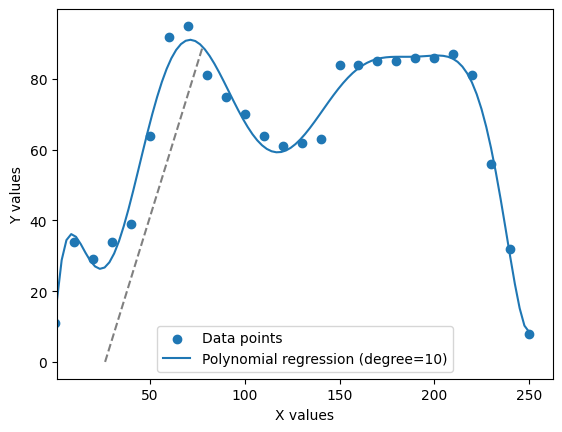

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

# Define a custom estimator class that wraps numpy.poly1d
class PolyRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, degree=1):
        self.degree = degree
 
    def fit(self, X, y=None):
        self.coeffs = np.polyfit(X.squeeze(), y, self.degree)
        return self

    def predict(self, X):
        return np.polyval(self.coeffs, X.squeeze())

# Define your data points
y = np.array([11, 34, 29, 34, 39, 64, 92, 95, 81, 75, 70, 64, 61, 62, 63, 84, 84, 85, 85, 86, 86, 87, 81, 56, 32, 8])

# Create x as a range of integers from 1 to 26
x = np.arange(len(y))*10

# Set the maximum degree of the polynomial
max_degree = 10

# Initialize lists to store the cross-validation scores and the degree values
cv_scores = []
degrees = np.arange(1, max_degree+1)

# Loop over the degree values and calculate the cross-validation scores for each degree
for degree in degrees:
    # Create a PolyRegressor object with the current degree
    model = PolyRegressor(degree=degree)

    # Calculate the cross-validation score for this degree
    cv_score = np.mean(cross_val_score(model, x.reshape(-1, 1), y, cv=5, scoring='neg_mean_squared_error'))
    cv_scores.append(cv_score)

# Find the degree with the best cross-validation score
best_degree = degrees[np.argmin(cv_scores)]

# Print the best degree
print(f"The best degree is {best_degree}")

# Fit a polynomial regression with the best degree to the data points
model = PolyRegressor(degree=best_degree)
model.fit(x.reshape(-1, 1), y)

# Generate x-values to plot the regression line
x_values = np.linspace(1, x[-1], 100)

# Calculate the y-values of the regression line
y_values = model.predict(x_values.reshape(-1, 1))

# Plot the data points and the regression line
plt.scatter(x, y, label='Data points')
plt.plot(x_values, y_values, label=f"Polynomial regression (degree={best_degree})")

# Add a legend and axis labels
plt.legend()
plt.xlabel('X values')
plt.ylabel('Y values')

# Generate x-values to plot the vertical lines
x_vertical = np.arange(-4.4, x[-1]+4.4, 4.4)
poly_func = model.predict

theta = np.deg2rad(60)
m = np.tan(theta)
x0 = x_vertical[7]
y0 = 0
line_func = lambda x: m*(x-x0) + y0

intersection_points = []
# Encontrar el punto de intersección entre la línea recta y la función polinómica
def intersection_func(x):
    return poly_func(x) - line_func(x)


x_intersect = fsolve(intersection_func, x0=x0, full_output=True)
y_intersect = line_func(x_intersect[0][0])

print(x_intersect)
print(y_intersect)
print(f'm:{m}')


intersection_points.append((x0, x_intersect[0][0], y0, y_intersect))

# Plot the vertical lines and intersection points
#print(intersection_points)
for point in intersection_points:
    x_coords = [point[0], point[1]]
    y_coords = [point[2], point[3]]
    plt.plot(x_coords, y_coords, linestyle='--', color='grey')

# Set the x-axis limits to start from the minimum x-value of the polynomial regression line
plt.xlim(left=min(x_values))

# Show the plot
plt.show()

The best degree is 10


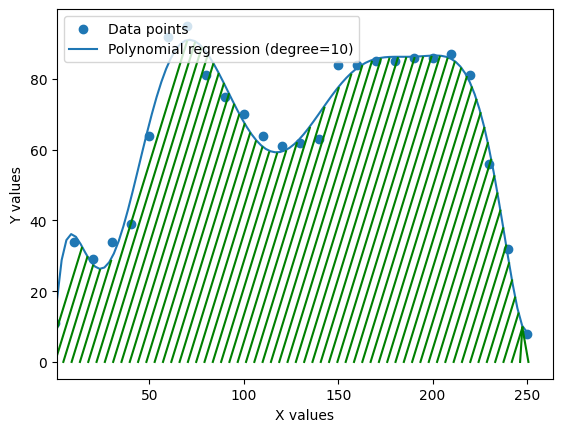

In [86]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

# Define a custom estimator class that wraps numpy.poly1d
class PolyRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, degree=1):
        self.degree = degree
 
    def fit(self, X, y=None):
        self.coeffs = np.polyfit(X.squeeze(), y, self.degree)
        return self

    def predict(self, X):
        return np.polyval(self.coeffs, X.squeeze())

# Define your data points
y = np.array([11, 34, 29, 34, 39, 64, 92, 95, 81, 75, 70, 64, 61, 62, 63, 84, 84, 85, 85, 86, 86, 87, 81, 56, 32, 8])

# Create x as a range of integers from 1 to 26
x = np.arange(len(y))*10

# Set the maximum degree of the polynomial
max_degree = 10

# Initialize lists to store the cross-validation scores and the degree values
cv_scores = []
degrees = np.arange(1, max_degree+1)

# Loop over the degree values and calculate the cross-validation scores for each degree
for degree in degrees:
    # Create a PolyRegressor object with the current degree
    model = PolyRegressor(degree=degree)

    # Calculate the cross-validation score for this degree
    cv_score = np.mean(cross_val_score(model, x.reshape(-1, 1), y, cv=5, scoring='neg_mean_squared_error'))
    cv_scores.append(cv_score)

# Find the degree with the best cross-validation score
best_degree = degrees[np.argmin(cv_scores)]

# Print the best degree
print(f"The best degree is {best_degree}")

# Fit a polynomial regression with the best degree to the data points
model = PolyRegressor(degree=best_degree)
model.fit(x.reshape(-1, 1), y)

# Generate x-values to plot the regression line
x_values = np.linspace(1, x[-1], 100)

# Calculate the y-values of the regression line
y_values = model.predict(x_values.reshape(-1, 1))

# Plot the data points and the regression line
plt.scatter(x, y, label='Data points')
plt.plot(x_values, y_values, label=f"Polynomial regression (degree={best_degree})")

# Add a legend and axis labels
plt.legend()
plt.xlabel('X values')
plt.ylabel('Y values')

# Generate x-values to plot the vertical lines
x_vertical = np.arange(-8.8, x[-1]+4.4, 4.4)
poly_func = model.predict

theta = np.deg2rad(60)
m = np.tan(theta)

# Find the intersection points between the vertical lines and the polynomial regression line
intersection_points = []
y_intersect = 0

x_vals = np.arange(0,x[-1],0.1)

for i in range(len(x_vertical)):
    x0 = x_vertical[i]
    y0 = 0
    line_func = lambda x: m*(x-x0) + y0
    #line_func = lambda x: m*(x-x0) + y0 if m*(x-x0) + y0 >= 0 else 0

    # Encontrar el punto de intersección entre la línea recta y la función polinómica
    def intersection_func(x):
        return abs(poly_func(x) - line_func(x))

    y_diff = 1

    for x_val in x_vals:
        y_diff = intersection_func(x_val)

        if(y_diff <= 0.5):
            x_intersect = x_val
            y_intersect = line_func(x_intersect)
            break

    intersection_points.append((x0, x_intersect, y0, y_intersect))


# Plot the vertical lines and intersection points
#print(intersection_points)
for point in intersection_points:
    x_coords = [point[0], point[1]]
    y_coords = [point[2], point[3]]
    plt.plot(x_coords, y_coords, color='green')

# Set the x-axis limits to start from the minimum x-value of the polynomial regression line
plt.xlim(left=min(x_values))

# Show the plot
plt.show()